# Propensity Model with Tree Ensemble Methods

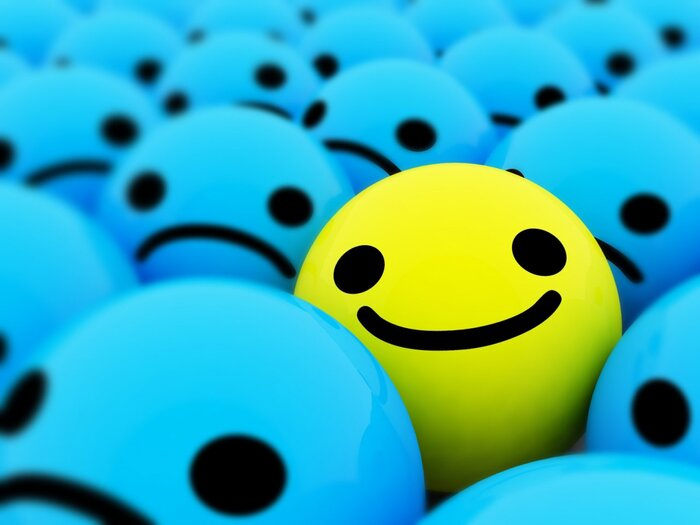

## Introduction

A propensity model is a type of statistical scorecard used to predict the behaviour of your prospective or existing customers, e.g. identifying those that are most likely to make a purchase or cancel their subscription. It is typically developed using observed historical data of customers performing a certain target action, thus making it a supervised learning problem, specifically binary classification.

In this notebook, we will attempt to model the relationship between the features and the target variable using tree ensemble techniques such as random forest and gradient-boosted tree.

## Business Problem

All companies have limited resources. As much as we would like to target or advertise to all prospective customers, or focus our efforts on retaining all existing customers, we are often unable to do so due to limited resources, e.g. budget or manpower. With a propensity model, we will be able to identify the group of customers that are most likely to make a purchase or churn, and we can then focus our efforts on this group of customers so as to optimise the usage of resources.

## Data

The data set was obtained from: https://archive.ics.uci.edu/ml/datasets/bank+marketing

> *The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).*

## Table of Contents

1. [Import libraries, data and functions](#head-1)
2. [Exploratory data analysis](#head-2)
3. [Categorical grouping](#head-3)
4. [Information value](#head-4)
5. [Correlation table](#head-5)
6. [Hyperparameter tuning](#head-6)
7. [Model training and evaluation](#head-7)
8. [Conclusion](#head-8)

# 1. Import libraries, data and functions <a class="anchor" id="head-1"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', None)

df = pd.read_csv('bank-additional-full.csv', sep=';')

# Define the target variable.
def purchase(row):
    if row['y'] == 'yes':
        val = 1
    else:
        val = 0
    return val

df['purchase'] = df.apply(purchase, axis=1)

# Split the data into train and test sets for cross validation.
df_train = df.sample(frac=0.8, random_state=2020)
df_test  = df.drop(df_train.index)

df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,purchase
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1


In [3]:
print('Train Shape:', df_train.shape)
print('Test Shape :', df_test.shape)

print('Train Purchase Rate:', round(df_train.purchase.sum() / len(df_train), 3))
print('Test Purchase Rate :', round(df_test.purchase.sum()  / len(df_test) , 3))

Train Shape: (32950, 22)
Test Shape : (8238, 22)
Train Purchase Rate: 0.113
Test Purchase Rate : 0.111


In [4]:
# There is no missing value in the data.
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
purchase          0
dtype: int64

In [5]:
# This function plots the bivariate relationship between the categorical feature and the target.
def bivariate_plot_categorical(df, feature, target):
    df_group = df.groupby(feature, as_index=False)[target].agg(['sum', 'count']).reset_index()
    df_group['purchase_prob'] = df_group['sum']   / df_group['count']
    df_group['proportion']    = df_group['count'] / df_group['count'].sum()
    
    fig, ax1 = plt.subplots(figsize=(7,4))
    
    ax1.set_title(feature, fontsize=16, fontweight='bold')
    ax1.set_facecolor('none')
    ax1=sns.barplot(x=feature, y='proportion', data=df_group, color='royalblue')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.xlabel('Feature Values', fontsize=14)
    plt.ylabel('Proportion', fontsize=14, color='navy')
    
    ax2=ax1.twinx()
    ax2.spines['left'].set_color('grey')
    ax2.spines['right'].set_color('grey')
    ax2.spines['bottom'].set_color('grey')
    ax2.plot(df_group[['purchase_prob']].values, color='red')
    ax2.set(ylim=(0))
    plt.yticks(fontsize=12)
    plt.ylabel('Purchase Probability', fontsize=14, color='firebrick')
    
    plt.show()

# This function plots the bivariate relationship between the numerical feature and the target.
def bivariate_plot_numerical(df, feature, target):
    if (df[[feature]].nunique() >= 10).bool():
        df = df[[feature, target]]
        df[feature].fillna(value=-9999999, inplace=True)
        df.sort_values(feature, ascending=True, inplace=True)
        df['nn'] = np.arange(len(df)) + 1
        bins = df.groupby(feature, as_index=False).first()
        bins['group'] = np.floor(10 * bins['nn'] / (len(df) + 1)) + 1
        bins.loc[bins[feature] == -9999999, 'group'] = 0
        df = df.merge(bins[[feature, 'group']], on=feature, how='left')
        final   = df.groupby('group', as_index=False)[target].agg(['sum', 'count']).reset_index()
        min_max = df.groupby('group', as_index=False)[feature].agg(['min', 'max']).reset_index()
        final   = final.merge(min_max, on='group', how='left')
    else:
        df[feature].fillna(value=-9999999, inplace=True)
        final   = df.groupby(feature, as_index=False)[target].agg(['sum', 'count']).reset_index()
        min_max = df.groupby(feature, as_index=False)[feature].agg(['min', 'max']).reset_index()
        final   = final.merge(min_max, on=feature, how='left')
    
    final['proportion']    = final['count'] / final['count'].sum()
    final['purchase_prob'] = final['sum']   / final['count']
    final['min_max']       = '['  + final['min'].astype(float).round(3).astype(str) + \
                             ', ' + final['max'].astype(float).round(3).astype(str) + ']'
    
    fig, ax1 = plt.subplots(figsize=(7,4))
    
    ax1.set_title(feature, fontsize=16, fontweight='bold')
    ax1.set_facecolor('none')
    ax1=sns.barplot(x='min_max', y='proportion', data=final, color='royalblue')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.xlabel('Feature Values', fontsize=14)
    plt.ylabel('Proportion', fontsize=14, color='navy')
    
    ax2=ax1.twinx()
    ax2.spines['left'].set_color('grey')
    ax2.spines['right'].set_color('grey')
    ax2.spines['bottom'].set_color('grey')
    ax2.plot(final[['purchase_prob']].values, color='red')
    ax2.set(ylim=(0))
    plt.yticks(fontsize=12)
    plt.ylabel('Purchase Probability', fontsize=14, color='firebrick')
    
    plt.show()

# This function computes the information value of the feature, which measures its predictiveness.
def information_value(df, feature, target, table):
    if (df[[feature]].nunique() >= 10).bool():
        df = df[[feature, target]]
        df[feature].fillna(value=-9999999, inplace=True)
        df.sort_values(feature, ascending=True, inplace=True)
        df['nn'] = np.arange(len(df)) + 1
        bins = df.groupby(feature, as_index=False).first()
        bins['group'] = np.floor(10 * bins['nn'] / (len(df) + 1)) + 1
        bins.loc[bins[feature] == -9999999, 'group'] = 0
        df = df.merge(bins[[feature, 'group']], on=feature, how='left')
        final   = df.groupby('group', as_index=False)[target].agg(['sum', 'count']).reset_index()
        min_max = df.groupby('group', as_index=False)[feature].agg(['min', 'max']).reset_index()
        final   = final.merge(min_max, on='group', how='left')
    else:
        df[feature].fillna(value=-9999999, inplace=True)
        final   = df.groupby(feature, as_index=False)[target].agg(['sum', 'count']).reset_index()
        min_max = df.groupby(feature, as_index=False)[feature].agg(['min', 'max']).reset_index()
        final   = final.merge(min_max, on=feature, how='left')
    
    final = final.rename(columns={'sum'  : 'purchase',
                                  'count': 'total'})
    final['no_purchase']    = final['total'] - final['purchase']
    final['purchase_prob']  = final['purchase'] / final['total']
    final['pct_events']     = np.maximum(final.purchase   , 1) / final['purchase'].sum()
    final['pct_non_events'] = np.maximum(final.no_purchase, 1) / final['no_purchase'].sum()
    final['woe']            = np.log(final['pct_events'] / final['pct_non_events'])
    final['iv']             = final['woe'] * (final['pct_events'] - final['pct_non_events'])
    final['iv_final']       = final['iv'].sum()
    iv = final['iv'].sum()
    
    if table:
        return final
    else:
        return iv.round(4)

# This function computes the Gini coefficient and KS statistic of the trained model.
def gini_ks(y_true, y_pred):
    df = np.concatenate((y_pred.reshape(-1, 1), y_true), axis=1)
    df = pd.DataFrame(df)
    df.columns = ['y_pred', 'y_true']
    df = df.groupby('y_pred', as_index=False)['y_true'].agg(['sum', 'count']).reset_index()
    df = df.rename(columns={'sum'  : 'purchase',
                            'count': 'total'})
    
    df['no_purchase']     = df['total'] - df['purchase']
    df['pct_no_purchase'] = df['no_purchase'] / df['no_purchase'].sum()
    df['pct_purchase']    = df['purchase']    / df['purchase'].sum()
    df['pct_total']       = df['total']       / df['total'].sum()
    
    df.sort_values('y_pred', ascending=False, inplace=True)
    df['cum_no_purchase'] = df['pct_no_purchase'].cumsum()
    df['cum_purchase']    = df['pct_purchase'].cumsum()
    df['cum_total']       = df['pct_total'].cumsum()
    
    df['gini'] = (df['cum_no_purchase'] + df['cum_no_purchase'].shift(1)) * \
                 (df['cum_purchase']    - df['cum_purchase'].shift(1)) / 2
    df['ks']   = df['cum_purchase'] - df['cum_no_purchase']
    
    gini = (0.5 - df['gini'].sum()) / 0.5
    ks   = df['ks'].max()
    
    print('Gini Coefficient:', round(gini, 5))
    print('KS Statistic    :', round(ks  , 5))
    
    purchase_prob = df['purchase'].sum() / df['total'].sum()
    ideal = pd.DataFrame({'x':[0, purchase_prob, 1], 'y':[0, 1, 1]})
    
    fig, ax_gini = plt.subplots(figsize=(7,5))
    ax_gini.set_facecolor('none')
    ax_gini.spines['left'].set_color('grey')
    ax_gini.spines['bottom'].set_color('grey')
    plt.plot(df['cum_total'], df['cum_purchase'], marker='.', markersize=1, color='red', label='Model Under Consideration')
    plt.plot([0, 1], [0, 1], color='midnightblue', label='Random Model')
    plt.plot(ideal['x'], ideal['y'], color='orange', label='Perfect Model')
    plt.title('Gini Coefficient: ' + str(round(gini, 3)), fontsize=16, fontweight='bold')
    plt.xlabel('Cumulative % of Population')
    plt.ylabel('Cumulative % of Purchase')
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.legend(loc='lower right', facecolor='white')
    plt.show()
    
    fig, ax_ks = plt.subplots(figsize=(7,5))
    ax_ks.set_facecolor('none')
    ax_ks.spines['left'].set_color('grey')
    ax_ks.spines['bottom'].set_color('grey')
    plt.plot(df['cum_total'], df['cum_purchase']   , marker='.', markersize=1, color='red'         , label='Cumulative % of Purchase')
    plt.plot(df['cum_total'], df['cum_no_purchase'], marker='.', markersize=1, color='midnightblue', label='Cumulative % of No Purchase')
    plt.title('KS Statistic: ' + str(round(ks, 3)), fontsize=16, fontweight='bold')
    plt.xlabel('Cumulative % of Population')
    plt.ylabel('Cumulative % of Purchase / No Purchase')
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.legend(loc='lower right', facecolor='white')
    plt.show()

# This function combines the predicted values with the actual target values for further analysis.
def combine_pred_actual(predictions, actual, train):
    if train:
        df = np.concatenate((predictions[:,1].reshape(-1, 1), actual.reshape(-1, 1)), axis=1)
    else:
        df = np.concatenate((predictions[:,1].reshape(-1, 1), actual), axis=1)
    df = pd.DataFrame(df)
    df.columns = ['predicted_probability', 'purchase']
    
    return df

# This function generates a table that summarises the count and number of purchases in each probability band.
def train_test_rank_ordering(train, test, num_bins):
    train.sort_values('predicted_probability', ascending=True, inplace=True)
    train['nn'] = np.arange(len(train)) + 1
    bins = train.groupby('predicted_probability', as_index=False).first()
    bins['group'] = np.floor(num_bins * bins['nn'] / (len(train) + 1)) + 1
    train = train.merge(bins[['predicted_probability', 'group']], on='predicted_probability', how='left')
    
    final_train = train.groupby('group', as_index=False)['purchase'].agg(['sum', 'count']).reset_index()
    min_max     = train.groupby('group', as_index=False)['predicted_probability'].agg(['mean', 'min', 'max']).reset_index()
    final_train = final_train.merge(min_max, on='group', how='left')
    
    final_train['proportion_train']              = final_train['count'] / final_train['count'].sum()
    final_train['actual_purchase_rate_train']    = final_train['sum']   / final_train['count']
    final_train['predicted_purchase_prob_train'] = final_train['mean']
    final_train.loc[0         , 'min'] = 0
    final_train.loc[num_bins-1, 'max'] = 1
    final_train['min_max'] = '['  + final_train['min'].astype(float).round(3).astype(str) + \
                             ', ' + final_train['max'].astype(float).round(3).astype(str) + ']'
    final_train = final_train.rename(columns={'sum'  : 'purchase_train',
                                              'count': 'count_train'})
    
    intervals = final_train[['min', 'min_max']]
    test.sort_values('predicted_probability', ascending=True, inplace=True)
    intervals.sort_values('min', ascending=True, inplace=True)
    
    test_grouped = pd.merge_asof(test, intervals, left_on='predicted_probability', right_on='min')
    final_test = test_grouped.groupby('min_max', as_index=False)['purchase'].agg(['sum', 'count']).reset_index()
    test_pred  = test_grouped.groupby('min_max', as_index=False)['predicted_probability'].mean().reset_index(drop=True)
    final_test = final_test.merge(test_pred, on='min_max', how='left')
    final_test = final_test.merge(test_grouped[['min_max', 'min']].drop_duplicates(), on='min_max', how='left')
    
    final_test['proportion_test']              = final_test['count'] / final_test['count'].sum()
    final_test['actual_purchase_rate_test']    = final_test['sum']   / final_test['count']
    final_test['predicted_purchase_prob_test'] = final_test['predicted_probability']
    final_test = final_test.rename(columns={'sum'  : 'purchase_test',
                                            'count': 'count_test'})
    
    final = final_train[['group',
                         'purchase_train',
                         'count_train',
                         'min',
                         'max',
                         'min_max',
                         'proportion_train',
                         'actual_purchase_rate_train',
                         'predicted_purchase_prob_train']].merge(final_test[['min_max',
                                                                             'purchase_test',
                                                                             'count_test',
                                                                             'proportion_test',
                                                                             'actual_purchase_rate_test',
                                                                             'predicted_purchase_prob_test']],
                                                                 on='min_max', how='left')
    final.sort_values('min', ascending=True, inplace=True)
    
    return final

# This function plots the proportion and purchase probability of each probability band in the train and test sets.
def plot_rank_ordering(df, algorithm):
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    ax1.set_title(algorithm + ' - Train vs Test Purchase Probabilities', fontsize=16, fontweight='bold')
    ax1.set_facecolor('none')
    ax1=sns.barplot(x='min_max', y='proportion_test', data=df, color='royalblue')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.xlabel('Probability Groups', fontsize=14)
    plt.ylabel('Proportion (Test)' , fontsize=14, color='midnightblue')
    
    ax2=ax1.twinx()
    ax2.spines['left'].set_color('grey')
    ax2.spines['right'].set_color('grey')
    ax2.spines['bottom'].set_color('grey')
    ax2.plot(df[['actual_purchase_rate_test']].values , color='red'   , label='Purchase Probability (Test)')
    ax2.plot(df[['actual_purchase_rate_train']].values, color='orange', label='Purchase Probability (Train)')
    ax2.set(ylim=(0))
    plt.legend(loc='lower right', facecolor='white')
    plt.yticks(fontsize=12)
    plt.ylabel('Purchase Probability', fontsize=14, color='firebrick')
    
    plt.show()

# 2. Exploratory data analysis <a class="anchor" id="head-2"></a>

Let's visualise the relationship between each feature and the target variable. The blue bars represent the proportion of customers in each bin while the red line represents the purchase probability for each bin.

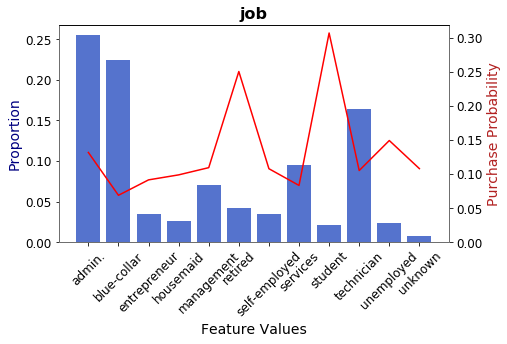

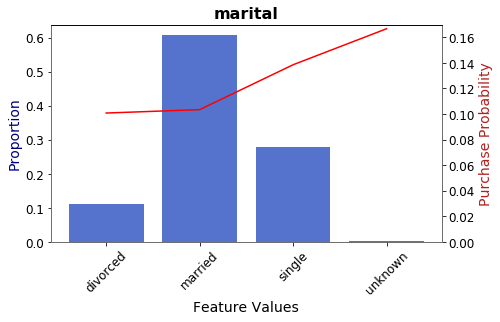

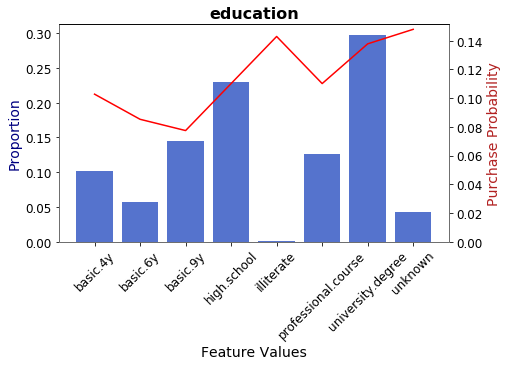

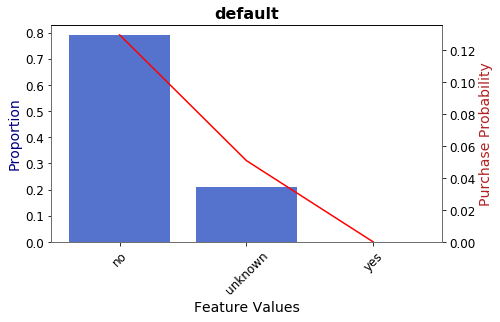

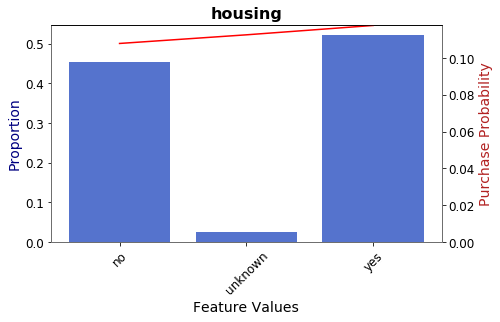

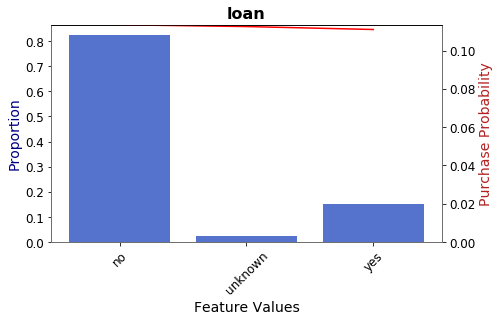

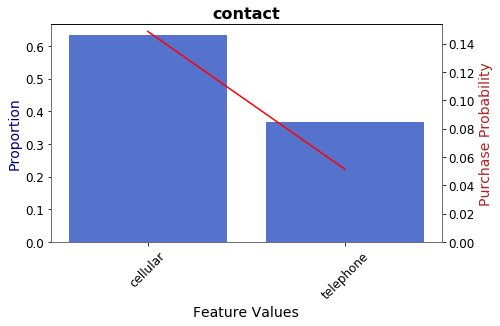

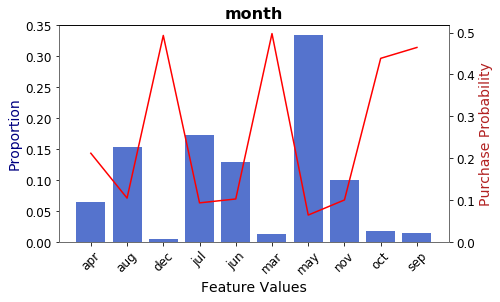

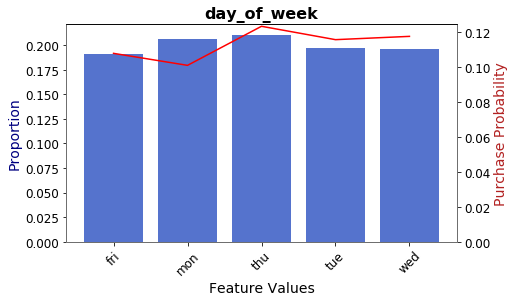

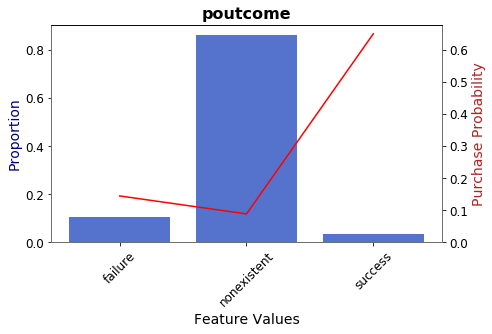

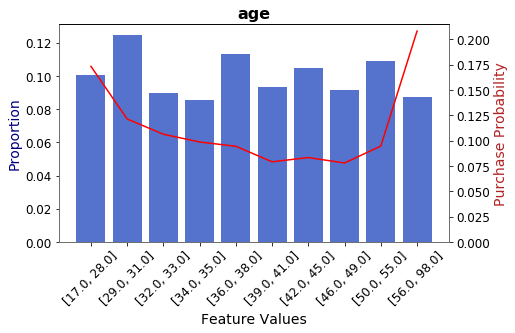

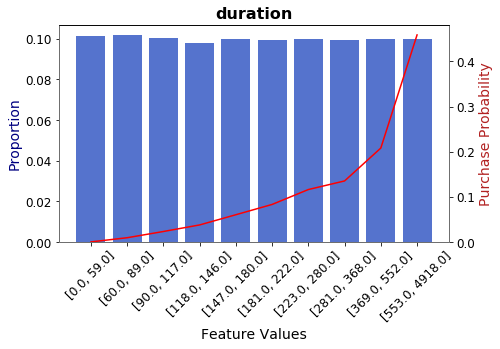

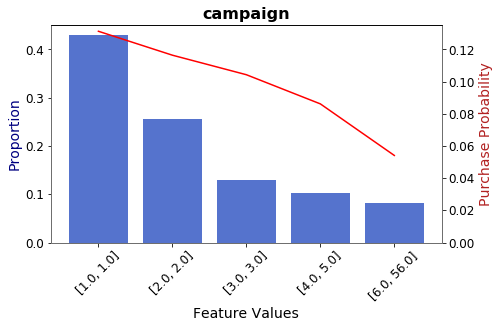

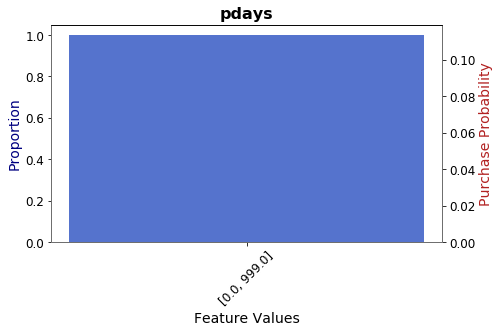

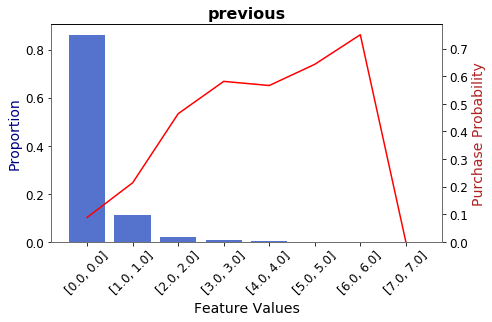

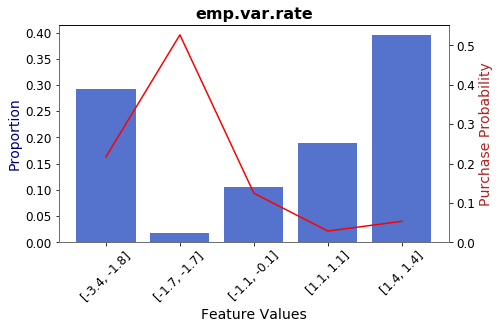

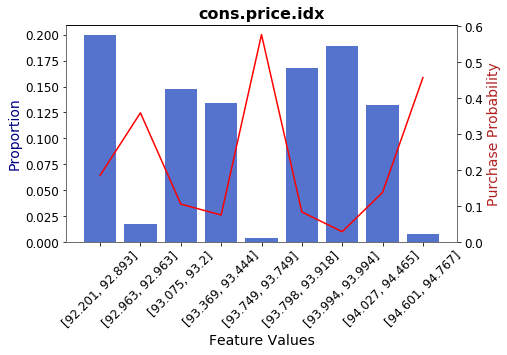

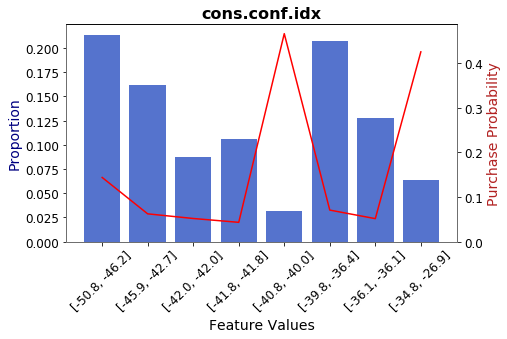

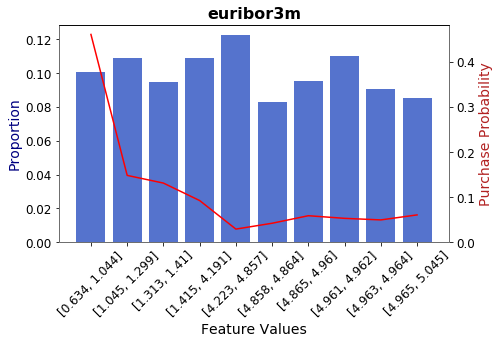

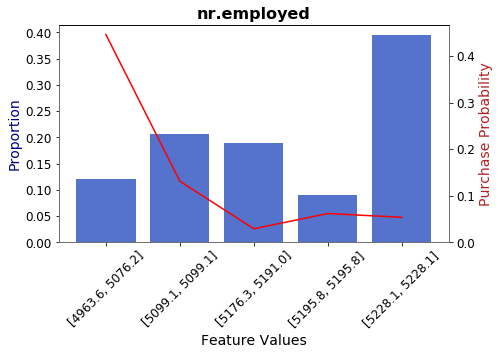

In [6]:
categorical_features = ['job',
                        'marital',
                        'education',
                        'default',
                        'housing',
                        'loan',
                        'contact',
                        'month',
                        'day_of_week',
                        'poutcome']

numerical_features   = ['age',
                        'duration',
                        'campaign',
                        'pdays',
                        'previous',
                        'emp.var.rate',
                        'cons.price.idx',
                        'cons.conf.idx',
                        'euribor3m',
                        'nr.employed']

for i in categorical_features:
    bivariate_plot_categorical(df_train, i, 'purchase')

for i in numerical_features:
    bivariate_plot_numerical(df_train, i, 'purchase')

# 3. Categorical grouping <a class="anchor" id="head-3"></a>

From the plots above, we are able to group certain bins with similar purchase probabilities together for the categorical features. The aim is to get a monotonic relationship between the defined groups and the target variable.

In [7]:
def categorical_job(row):
    if row['job'] in ('student'):
        val = 1
    elif row['job'] in ('retired'):
        val = 2
    elif row['job'] in ('admin.'):
        val = 3
    elif row['job'] in ('blue-collar'):
        val = 5
    else:
        val = 4
    return val

def categorical_marital(row):
    if row['marital'] in ('single', 'unknown'):
        val = 1
    elif row['marital'] in ('married'):
        val = 2
    else:
        val = 3
    return val

def categorical_education(row):
    if row['education'] in ('illiterate', 'unknown'):
        val = 1
    elif row['education'] in ('university.degree'):
        val = 2
    elif row['education'] in ('professional.course', 'high.school'):
        val = 3
    else:
        val = 4
    return val

def categorical_default(row):
    if row['default'] in ('no'):
        val = 1
    elif row['default'] in ('unknown'):
        val = 2
    else:
        val = 3
    return val

def categorical_housing(row):
    if row['housing'] in ('yes'):
        val = 1
    elif row['housing'] in ('unknown'):
        val = 2
    else:
        val = 3
    return val

def categorical_loan(row):
    if row['loan'] in ('no'):
        val = 1
    elif row['loan'] in ('unknown'):
        val = 2
    else:
        val = 3
    return val

def categorical_contact(row):
    if row['contact'] in ('cellular'):
        val = 1
    else:
        val = 2
    return val

def categorical_month(row):
    if row['month'] in ('mar', 'sep', 'oct', 'dec'):
        val = 1
    else:
        val = 2
    return val

def categorical_day_of_week(row):
    if row['day_of_week'] in ('tue', 'wed', 'thu'):
        val = 1
    elif row['day_of_week'] in ('fri'):
        val = 2
    else:
        val = 3
    return val

def categorical_poutcome(row):
    if row['poutcome'] in ('success'):
        val = 1
    elif row['poutcome'] in ('failure'):
        val = 2
    else:
        val = 3
    return val

df_train['cat_job']         = df_train.apply(categorical_job        , axis=1)
df_train['cat_marital']     = df_train.apply(categorical_marital    , axis=1)
df_train['cat_education']   = df_train.apply(categorical_education  , axis=1)
df_train['cat_default']     = df_train.apply(categorical_default    , axis=1)
df_train['cat_housing']     = df_train.apply(categorical_housing    , axis=1)
df_train['cat_loan']        = df_train.apply(categorical_loan       , axis=1)
df_train['cat_contact']     = df_train.apply(categorical_contact    , axis=1)
df_train['cat_month']       = df_train.apply(categorical_month      , axis=1)
df_train['cat_day_of_week'] = df_train.apply(categorical_day_of_week, axis=1)
df_train['cat_poutcome']    = df_train.apply(categorical_poutcome   , axis=1)

df_test['cat_job']          = df_test.apply(categorical_job         , axis=1)
df_test['cat_marital']      = df_test.apply(categorical_marital     , axis=1)
df_test['cat_education']    = df_test.apply(categorical_education   , axis=1)
df_test['cat_default']      = df_test.apply(categorical_default     , axis=1)
df_test['cat_housing']      = df_test.apply(categorical_housing     , axis=1)
df_test['cat_loan']         = df_test.apply(categorical_loan        , axis=1)
df_test['cat_contact']      = df_test.apply(categorical_contact     , axis=1)
df_test['cat_month']        = df_test.apply(categorical_month       , axis=1)
df_test['cat_day_of_week']  = df_test.apply(categorical_day_of_week , axis=1)
df_test['cat_poutcome']     = df_test.apply(categorical_poutcome    , axis=1)

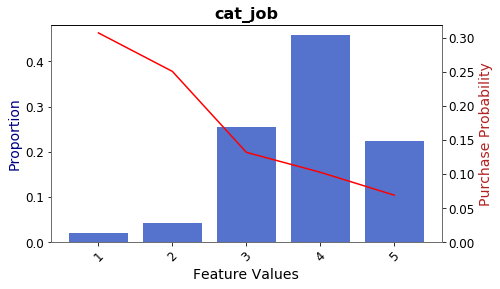

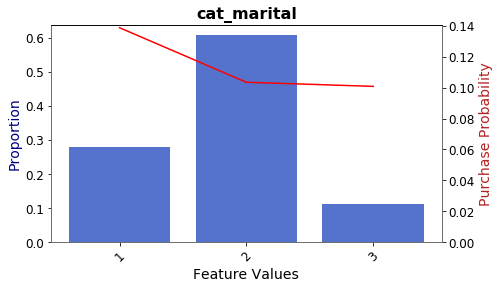

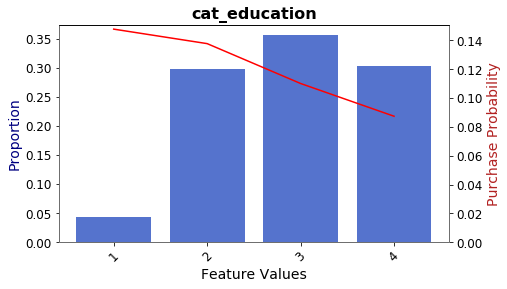

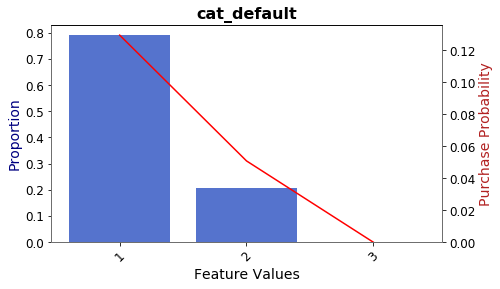

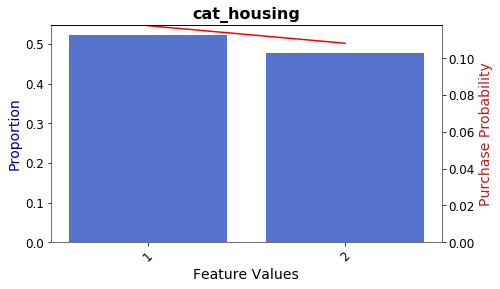

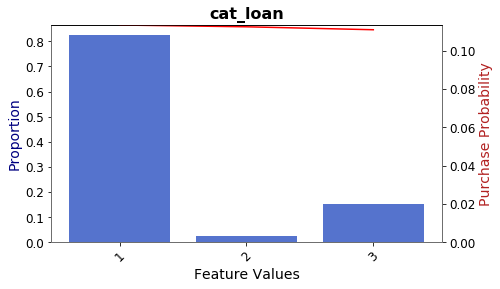

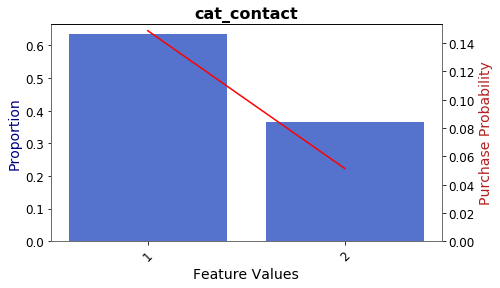

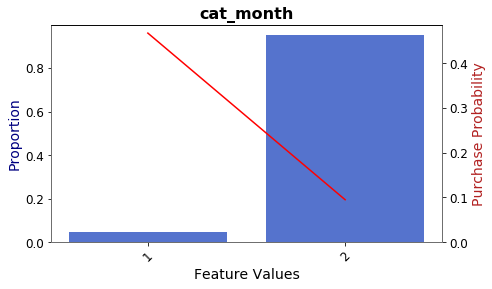

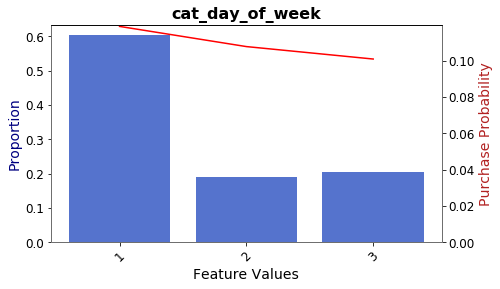

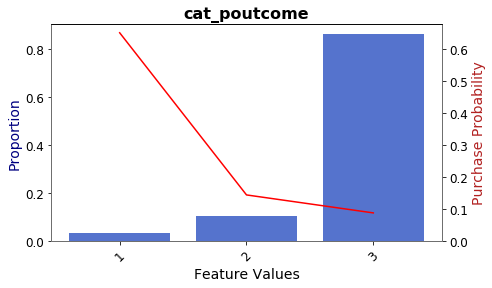

In [8]:
# We generate the plots once again to confirm the monotonic relationship between the grouped features and the target.
bivariate_plot_categorical(df_train, 'cat_job'        , 'purchase')
bivariate_plot_categorical(df_train, 'cat_marital'    , 'purchase')
bivariate_plot_categorical(df_train, 'cat_education'  , 'purchase')
bivariate_plot_categorical(df_train, 'cat_default'    , 'purchase')
bivariate_plot_categorical(df_train, 'cat_housing'    , 'purchase')
bivariate_plot_categorical(df_train, 'cat_loan'       , 'purchase')
bivariate_plot_categorical(df_train, 'cat_contact'    , 'purchase')
bivariate_plot_categorical(df_train, 'cat_month'      , 'purchase')
bivariate_plot_categorical(df_train, 'cat_day_of_week', 'purchase')
bivariate_plot_categorical(df_train, 'cat_poutcome'   , 'purchase')

# 4. Information value <a class="anchor" id="head-4"></a>

Next, we compute the information value (IV) of each feature, which is a measure of its individual predictiveness. We will drop features with low predictiveness, i.e. below 2%.

In [9]:
categorical_features_grouped = []
for i in categorical_features:
    categorical_features_grouped.append('cat_' + i)

all_features = categorical_features_grouped + numerical_features

information_value_results = []
for i in all_features:
    information_value_results.append([i, information_value(df_train, i, 'purchase', table=False)])
information_value_results = pd.DataFrame(information_value_results, columns=['feature', 'information_value'])
information_value_results.sort_values(by='information_value', ascending=False, inplace=True)
information_value_results['rank'] = np.arange(len(information_value_results)) + 1

information_value_results

,feature,information_value,rank
11,duration,1.9675,1
19,nr.employed,1.1965,2
18,euribor3m,1.0697,3
17,cons.conf.idx,0.8689,4
15,emp.var.rate,0.8251,5
9,cat_poutcome,0.5486,6
16,cons.price.idx,0.5261,7
7,cat_month,0.3652,8
14,previous,0.3522,9
6,cat_contact,0.2646,10


# 5. Correlation table <a class="anchor" id="head-5"></a>

We observe the correlation among the features and drop feature(s) with high correlation, i.e. above 70%.

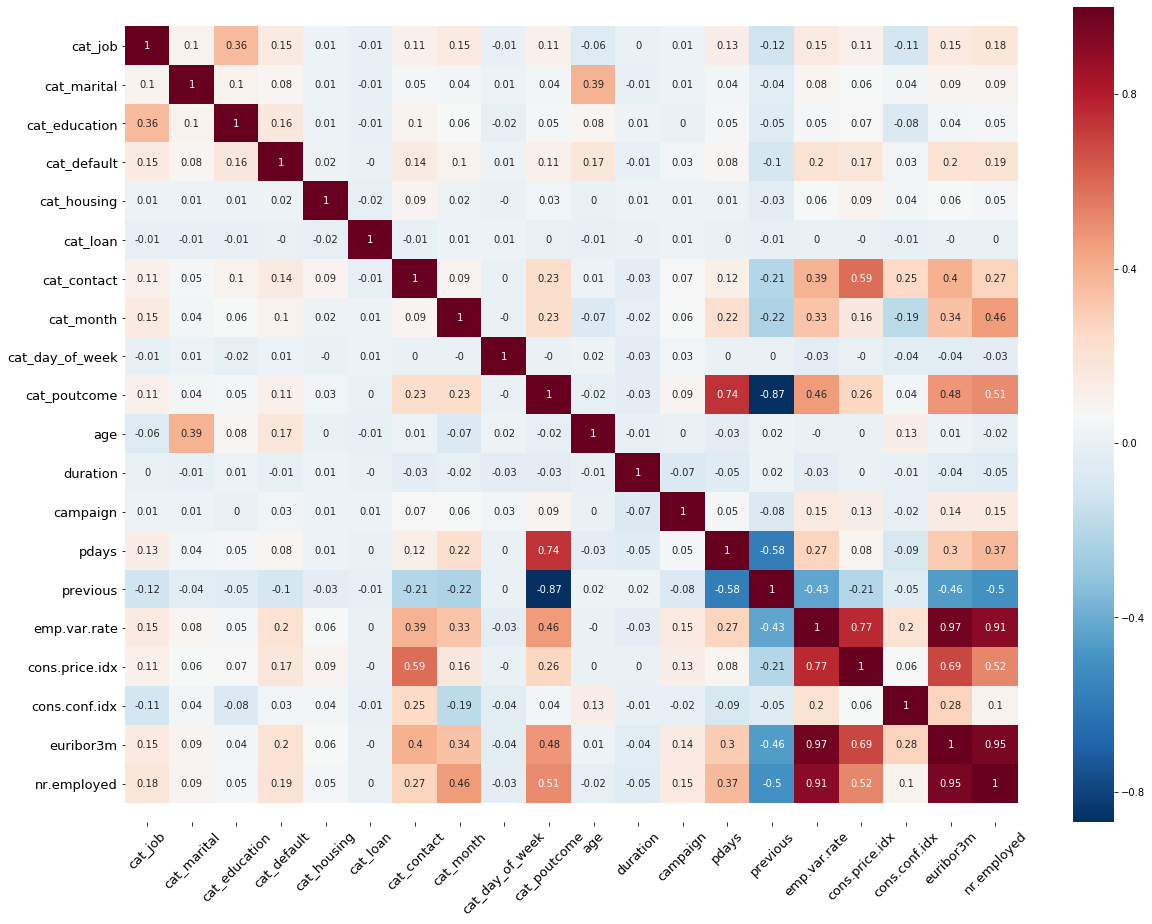

In [10]:
features = df_train[all_features]

pearson_corr = features.corr(method='pearson').round(2)

plt.subplots(figsize=(20,15))

sns.heatmap(pearson_corr,
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0)

bottom, top = plt.ylim()
bottom += 0.5
top    -= 0.5
plt.ylim(bottom, top)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# 6. Hyperparameter tuning <a class="anchor" id="head-6"></a>

Once we drop the least predictive, highly correlated and unintuitive features, we will perform hyperparameter tuning using the final shortlisted features to select the optimal set of hyperparameters. Given that this is a binary classification problem, we will experiment with random forest and gradient-boosted tree algorithms. With the small amount of data and features that we have, deep learning will not be required.

In [11]:
drop_list = ['cat_day_of_week',   # IV < 2%
             'cat_housing',       # IV < 2%
             'cat_loan',          # IV < 2%
             'pdays',             # IV < 2%
             'previous',          # High correlation
             'emp.var.rate',      # Why would employment variation rate affect purchase probability?
             'nr.employed',       # Why would number of employees affect purchase probability?
             'duration']

final_features = [i for i in all_features if i not in drop_list]

X_train = df_train[final_features].values
y_train = df_train[['purchase']].values.ravel()

X_test = df_test[final_features].values
y_test = df_test[['purchase']].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(32950, 12)
(32950,)
(8238, 12)
(8238, 1)


In [12]:
rf_parameters = {'n_estimators'    : [50, 100, 200, 300],
                 'max_depth'       : [4, 6, 8, 10],
                 'min_samples_leaf': [10, 30, 50],
                 'max_samples'     : [0.8, None]}

rf_model = RandomForestClassifier(random_state=2020)

rf_gridsearch = GridSearchCV(
                    estimator  = rf_model,
                    param_grid = rf_parameters,
                    scoring    = 'roc_auc',
                    cv         = 3,
                    n_jobs     = 5,
                    verbose    = 2
                    )

rf_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   27.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  5.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2020),
             n_jobs=5,
             param_grid={'max_depth': [4, 6, 8, 10], 'max_samples': [0.8, None],
                         'min_samples_leaf': [10, 30, 50],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='roc_auc', verbose=2)

In [13]:
rf_gridsearch.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=50,
                       random_state=2020)

In [14]:
rf_gridsearch.best_score_

0.8042028795463434

In [15]:
xgb_parameters = {'n_estimators'    : [50, 100, 200, 300],
                  'max_depth'       : [4, 6, 8, 10],
                  'learning_rate'   : [0.1, 0.2],
                  'subsample'       : [0.8, 1.0]}

xgb_model = XGBClassifier(random_state=2020)

xgb_gridsearch = GridSearchCV(
                    estimator  = xgb_model,
                    param_grid = xgb_parameters,
                    scoring    = 'roc_auc',
                    cv         = 3,
                    n_jobs     = 5,
                    verbose    = 2
                    )

xgb_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   46.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done 192 out of 192 | elapsed: 10.0min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=2020,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [16]:
xgb_gridsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
xgb_gridsearch.best_score_

0.8047006687164893

# 7. Model training and evaluation <a class="anchor" id="head-7"></a>

After training both models using the optimal set of hyperparameters, we observe that:

1. Gradient-boosted tree performs slightly better than random forest (Gini of 59.5% vs 58.2%).
2. There is no significant overfitting in both models.

--- Test Results (Random Forest) ---
AUC             : 0.79118
Gini Coefficient: 0.58236
KS Statistic    : 0.4935


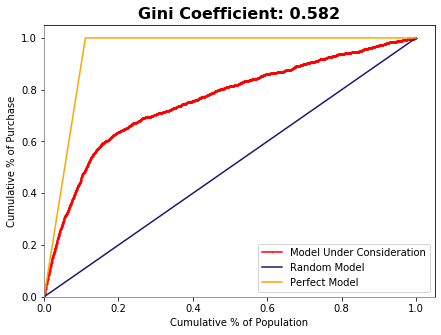

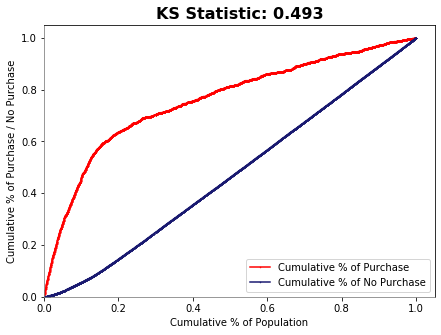

--- Train Results (Random Forest) ---
AUC             : 0.83266
Gini Coefficient: 0.66532
KS Statistic    : 0.52124


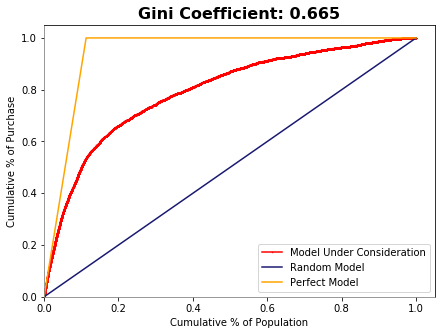

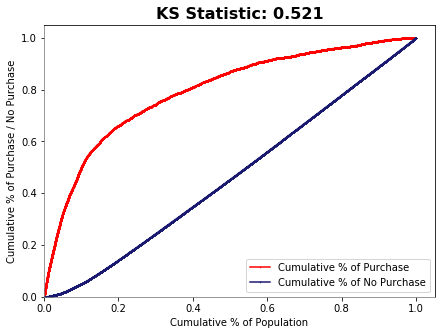

In [18]:
rf = RandomForestClassifier(n_estimators     = 50,
                            max_depth        = 10,
                            min_samples_leaf = 10,
                            max_samples      = None,
                            random_state     = 2020)

rf.fit(X_train, y_train)

y_pred_proba_rf_test  = rf.predict_proba(X_test)
y_pred_proba_rf_train = rf.predict_proba(X_train)

print('--- Test Results (Random Forest) ---')
print('AUC             :', round(roc_auc_score(y_test , y_pred_proba_rf_test[:,1]) , 5))   # Gini = 2 * AUC - 1
gini_ks(y_test, y_pred_proba_rf_test[:,1])

print('--- Train Results (Random Forest) ---')
print('AUC             :', round(roc_auc_score(y_train, y_pred_proba_rf_train[:,1]), 5))
gini_ks(y_train.reshape(-1, 1), y_pred_proba_rf_train[:,1])

--- Test Results (XGBoost) ---
AUC             : 0.79729
Gini Coefficient: 0.59458
KS Statistic    : 0.49514


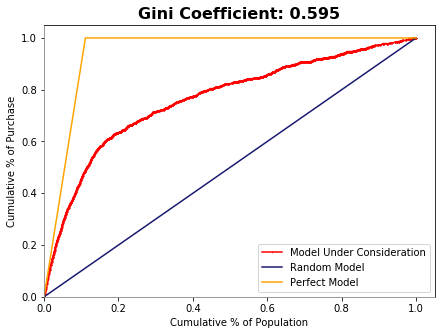

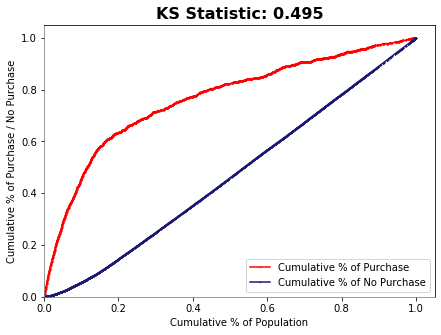

--- Train Results (XGBoost) ---
AUC             : 0.83762
Gini Coefficient: 0.67525
KS Statistic    : 0.53022


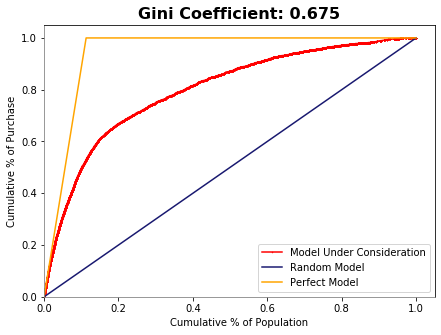

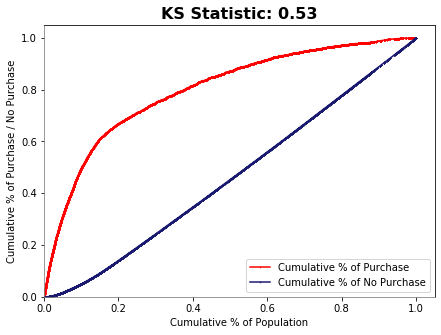

In [19]:
xgb = XGBClassifier(n_estimators  = 50,
                    max_depth     = 6,
                    learning_rate = 0.1,
                    subsample     = 1.0,
                    random_state  = 2020)

xgb.fit(X_train, y_train)

y_pred_proba_xgb_test  = xgb.predict_proba(X_test)
y_pred_proba_xgb_train = xgb.predict_proba(X_train)

print('--- Test Results (XGBoost) ---')
print('AUC             :', round(roc_auc_score(y_test , y_pred_proba_xgb_test[:,1]) , 5))   # Gini = 2 * AUC - 1
gini_ks(y_test, y_pred_proba_xgb_test[:,1])

print('--- Train Results (XGBoost) ---')
print('AUC             :', round(roc_auc_score(y_train, y_pred_proba_xgb_train[:,1]), 5))
gini_ks(y_train.reshape(-1, 1), y_pred_proba_xgb_train[:,1])

In [20]:
train_predictions_rf  = combine_pred_actual(y_pred_proba_rf_train , y_train, train=True )
test_predictions_rf   = combine_pred_actual(y_pred_proba_rf_test  , y_test , train=False)

train_predictions_xgb = combine_pred_actual(y_pred_proba_xgb_train, y_train, train=True )
test_predictions_xgb  = combine_pred_actual(y_pred_proba_xgb_test , y_test , train=False)

In [21]:
df_rank_ordered_rf  = train_test_rank_ordering(train_predictions_rf , test_predictions_rf , 10)
df_rank_ordered_xgb = train_test_rank_ordering(train_predictions_xgb, test_predictions_xgb, 10)

df_rank_ordered_xgb

,group,purchase_train,count_train,min,max,min_max,proportion_train,actual_purchase_rate_train,predicted_purchase_prob_train,purchase_test,count_test,proportion_test,actual_purchase_rate_test,predicted_purchase_prob_test
0,1.0,46.0,3361,0.000000,0.028932,"[0.0, 0.029]",0.102003,0.013686,0.025011,24.0,779,0.094562,0.030809,0.024906
1,2.0,61.0,3229,0.028945,0.038006,"[0.029, 0.038]",0.097997,0.018891,0.033650,31.0,850,0.103180,0.036471,0.033634
2,3.0,87.0,3297,0.038011,0.044057,"[0.038, 0.044]",0.100061,0.026388,0.041168,30.0,812,0.098568,0.036946,0.041189
3,4.0,120.0,3302,0.044064,0.049967,"[0.044, 0.05]",0.100212,0.036342,0.046899,41.0,807,0.097961,0.050805,0.046864
4,5.0,164.0,3286,0.049975,0.058142,"[0.05, 0.058]",0.099727,0.049909,0.053832,31.0,776,0.094198,0.039948,0.054023
5,6.0,208.0,3321,0.058142,0.066365,"[0.058, 0.066]",0.100789,0.062632,0.062040,44.0,818,0.099296,0.053790,0.062026
6,7.0,245.0,3274,0.066384,0.076749,"[0.066, 0.077]",0.099363,0.074832,0.071538,57.0,887,0.107672,0.064262,0.071552
7,8.0,301.0,3290,0.076794,0.122243,"[0.077, 0.122]",0.099848,0.091489,0.095558,75.0,826,0.100267,0.090799,0.095032
8,9.0,645.0,3295,0.122296,0.324118,"[0.122, 0.324]",0.100000,0.195751,0.209390,169.0,866,0.105123,0.195150,0.205182
9,10.0,1848.0,3295,0.324147,1.000000,"[0.324, 1.0]",0.100000,0.560850,0.515274,413.0,817,0.099175,0.505508,0.512537


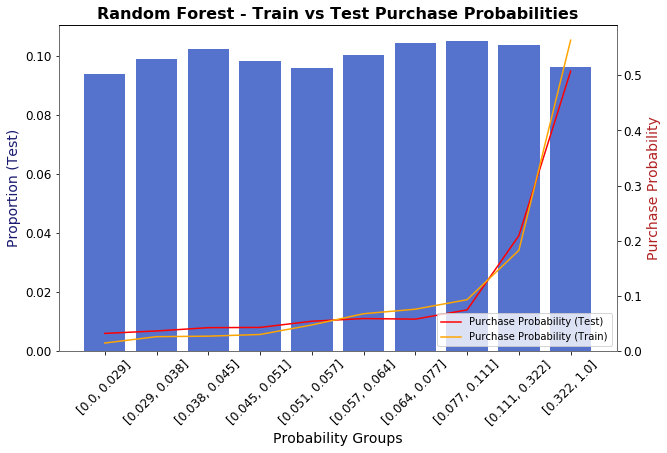

In [22]:
plot_rank_ordering(df_rank_ordered_rf, 'Random Forest')

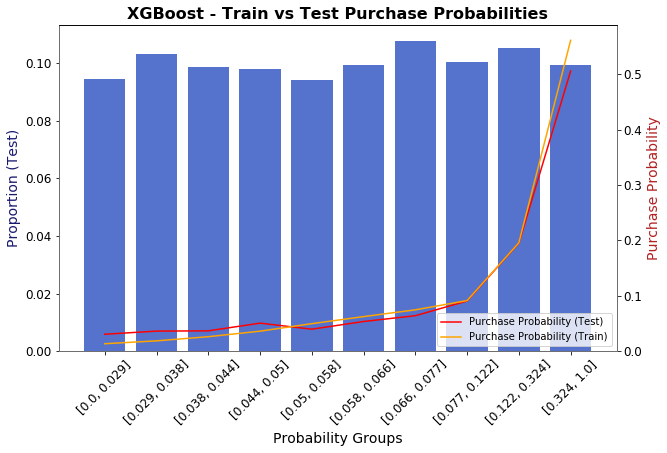

In [23]:
plot_rank_ordering(df_rank_ordered_xgb, 'XGBoost')

# 8. Conclusion <a class="anchor" id="head-8"></a>

From the results above, we arrive at the following key points regarding the model:

1. We can develop a decent propensity model using <b>XGBoost algorithm</b> and <b>12 features</b>.
2. The final model has an <b>AUC of 79.7%</b> and a <b>Gini coefficient of 59.5%</b> on the test set.

The business impact is summarised below:

1. By targeting just the top <b>20%</b> of all prospective customers, we will be able to convert approximately <b>60%</b> of all converted customers.
2. Alternatively, if we were to increase our efforts by targeting the top <b>40%</b> of all prospective customers, we will be able to convert approximately <b>80%</b> of all converted customers.
3. This translates to a <b>cost/manpower savings of 60-80%</b>, while still reasonably achieving our business goal.